# 1. Extracted iCAPS

In [1]:
from src import *

In [2]:
def get_onecaps(volume, affine, idx):
    """
    Simply get specific index of iCAPS to then allow for visualization in nifti format
    """
    ret = nib.Nifti1Image(volume[:,:,:,idx], affine=affine)
    return ret

def get_allcaps(clustering_path, zscored=True):

    if zscored:
        data_dict = mat73.loadmat(root + clustering_path + 'K_20_Dist_cosine_Folds_10/iCAPs_z.mat')
    else:
        data_dict = mat73.loadmat(root + clustering_path + 'K_20_Dist_cosine_Folds_10/iCAPs.mat')
    mask_dict = mat73.loadmat(root + clustering_path + 'final_mask.mat')

    icaps = np.zeros((91,109,91,20),dtype=float)
    for i in range(20):
        dummy = np.array(np.zeros_like(mask_dict['final_mask']), dtype=float)
        if zscored:
            dummy[mask_dict['final_mask']] = data_dict['iCAPs_z'][i]
        else:
            dummy[mask_dict['final_mask']] = data_dict['iCAPs'][i]
        dummy = dummy.reshape(91,109,91)
        dummy = dummy.T
        icaps[:,:,:,i] = dummy
    
    return icaps

from scipy.spatial import distance
from scipy.stats import pearsonr

def thresholding_allcaps(tothresh,perc=99):
    ret = np.zeros_like(tothresh)
    for k in range(tothresh.shape[1]):
        row = tothresh[:,k]
        ret[row>np.percentile(row,perc),k] = row[row>np.percentile(row,perc)]        
    
    return ret

def costmatrix(points, metric='cosine'):
    """
    Compute distance matrix between high-dimensional points
    """
    ret = np.zeros((len(points), len(points)))
    for k in range(len(points)):
        for j in range(len(points)):
            A = points[k]
            B = points[j]
#             A = points[k][(points[k] != 0) & (points[j]!= 0)]
#             B = points[j][(points[k] != 0) & (points[j] != 0)]            
            if metric == 'cosine':
                ret[k,j] = distance.cosine(A,B)
            elif metric == 'correlation':
                ret[k,j] = 1 - pearsonr(A,B).correlation
                
    return ret

## Table of Contents
- [iCAPS](#emotion)
    - Reformatting
    - Exploring
- [Factor Analysis data](#3fa)
    - Exploring
- [Personality index data](#pidx)
    - Exploring

- [fMRI data](#fmri)
    - Reformatting
    - Exploring

## Description

After extracting the iCAPS from the Emo Dataset we are interested in observing and aggregating the results.

GOAL: Visualize the (group level and individual level) iCAPS

In [3]:
root = '/media/miplab-nas2/Data2/Movies_Emo/Michael/DATA/fmri_tcs/'

ids = [filename.strip('sub-') for filename in os.listdir(root) if filename.startswith('sub')]
clust_roots = ['iCAPs_results/iCAPS_Emo_Movies_sub-{}_Alpha_5_95_Fraction_0DOT05/'.format(_id) for _id in ids]

clust_roots

['iCAPs_results/iCAPS_Emo_Movies_sub-S01_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S02_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S03_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S04_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S05_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S06_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S07_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S08_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S09_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S10_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S11_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S13_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S14_Alpha_5_95_Fraction_0DOT05/',
 'iCAPs_results/iCAPS_Emo_Movies_sub-S15_Alpha_5_95_Fraction_0DOT05/',
 'iCAP

In [8]:
# Example affine for MNI used to display values
tmp = nib.load('/home/chchan/michael-server/Michael/DATA/fmri_tcs/iCAPs_results/iCAPS_Emo_Movies_sub-S07_Alpha_5_95_Fraction_0DOT05/final_mask.nii')

mnishape = 91 * 109 * 91

### Visualize 1-subject iCAPS

In [5]:
icaps1 = get_allcaps(clust_roots[0])

nib_caps1 = get_onecaps(icaps1, tmp.affine, 0)
nib_caps2 = get_onecaps(icaps1, tmp.affine, 1)
nib_caps3 = get_onecaps(icaps1, tmp.affine, 2)

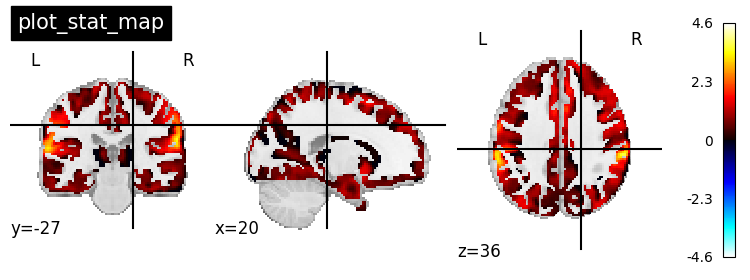

In [12]:
plotting.plot_stat_map(nib_caps1,
                       # threshold=1.5,
                       title="plot_stat_map",
                       cut_coords=[20, -27, 36])

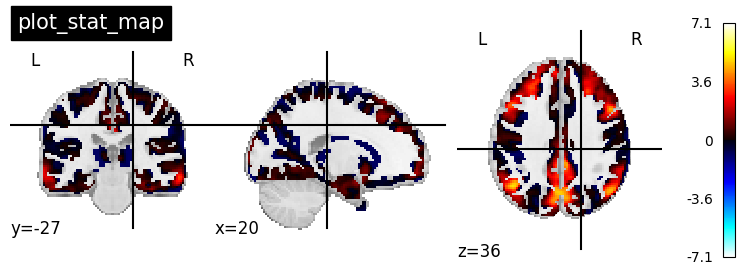

In [13]:
plotting.plot_stat_map(nib_caps2,
                       # threshold=1.5,
                       title="plot_stat_map",
                       cut_coords=[20, -27, 36])

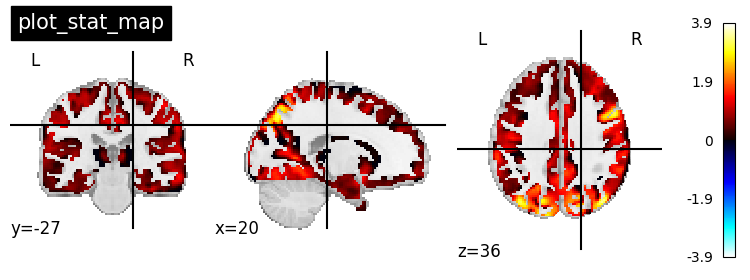

In [14]:
plotting.plot_stat_map(nib_caps3,
                       # threshold=1.5,
                       title="plot_stat_map",
                       cut_coords=[20, -27, 36])

### Hungarian Matching
#### (Hard coded paths as this step done through matlab scripts)

In [17]:
# Loading icaps
icapss = [get_allcaps(clust_roots[i]).reshape(-1,20) for i in range(len(ids))]
# thresholding when computing the matching so that only high stats matters in matching
ticapss = [thresholding_allcaps(icapss[i], perc=95) for i in range(len(ids))]

cluster_matchings = [np.zeros((mnishape, 20 * 2)) for _ in range(len(ids)-1)]
for i in range(len(ids)-1):
    cluster_matchings[i][:,:20] = ticapss[0]
    cluster_matchings[i][:,20:40] = ticapss[i+1]

In [18]:
for k in tqdm(range(len(ids)-1)):
    cmat = costmatrix(cluster_matchings[k].T, metric='cosine')
    
    # We keep only 1 quadrant
    cmat2 = deepcopy(cmat[:20,20:])
    hdf5storage.write({'cmat':cmat2}, path='.',
                      filename='costmat{}-{}.mat'.format(ids[0],ids[k+1]),
                      matlab_compatible=True)

100%|█| 14/14 [11:46<00


In [35]:
import shutil
for k in tqdm(range(len(ids)-1)):
    shutil.move("costmat{}-{}.mat".format(ids[0],ids[k+1]), "./hungarian_match/costmatrices/costmat{}-{}.mat".format(ids[0],ids[k+1]))

100%|█| 14/14 [00:00<00


example of munkres to run:
```console
chchan@miplabsrv2:matlab

run_munkres
```

In [39]:
assigns = []
for k in range(len(ids)-1):
    assign = mat73.loadmat('./hungarian_match/results/assignment{}-{}.mat'.format(ids[0],ids[k+1]))['assignment']
    assigns.append(assign)
    print(mat73.loadmat('./hungarian_match/results/cost{}-{}.mat'.format(ids[0],ids[k+1]))['cost'])
    
assigns = np.asarray(assigns, dtype=int) - 1

8.485661855913678
8.885007837223771
8.42629062176477
8.822989756084398
8.538023997272541
8.422219145596188
8.442634708805427
9.02248222376055
8.25588943899647
8.413267535418766
8.427285108696031
8.512496160024998
8.668539539931784
8.295356655415382


#### (python version)

In [15]:
# Loading icaps
icapss = [get_allcaps(clust_roots[i]).reshape(-1,20) for i in range(len(ids))]
# thresholding when computing the matching so that only high stats matters in matching
ticapss = [thresholding_allcaps(icapss[i], perc=95) for i in range(len(ids))]

In [21]:
cluster_matchings = [np.zeros((mnishape, 20 * 2)) for _ in range(len(ids)-1)]
for i in range(len(ids)-1):
    cluster_matchings[i][:,:20] = icapss[0]
    cluster_matchings[i][:,20:40] = icapss[i+1]

In [22]:
from scipy.optimize import linear_sum_assignment

In [28]:
costmatrices = []
for k in tqdm(range(len(ids)-1)):
    cmat = costmatrix(cluster_matchings[k].T, metric='cosine')
    costmatrices.append(cmat)

100%|█| 16/16 [13:02<00


In [33]:
ncostmatrices = [costmatrices[k][:20,20:40] for k in range(len(costmatrices))]

In [53]:
assigns = []
for k in range(len(ncostmatrices)):
    row_indices, col_indices = linear_sum_assignment(ncostmatrices[k])
    assignment = [(row, col) for row, col in zip(row_indices, col_indices)]
    assigns.append(assignment)

In [42]:
icapss_vol = [get_allcaps(clust_roots[i]) for i in range(len(ids))]

#### Visualize the matchings whether they make sense or not for a pair

In [64]:
pair = 5
icaps1 = icapss_vol[0]
icaps2 = icapss_vol[pair]

idx = 1
nib_caps1 = get_onecaps(icaps1, tmp.affine, idx)
nib_caps2 = get_onecaps(icaps2, tmp.affine, assigns[pair-1][idx][1])

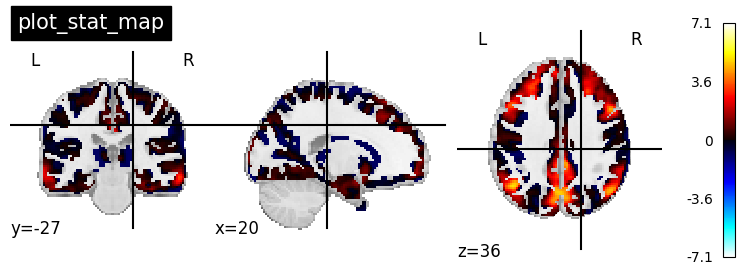

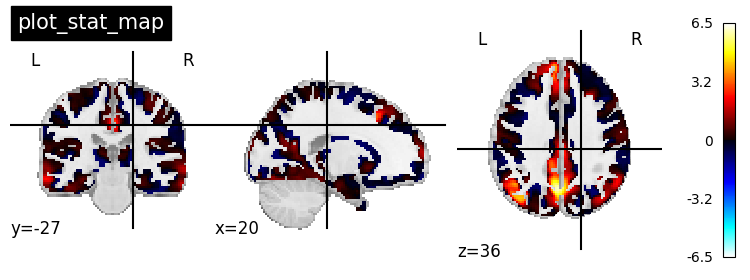

In [65]:
plotting.plot_stat_map(nib_caps1,
                       # threshold=np.percentile(icaps1[:,:,:,idx],99),
                       title="plot_stat_map",
                      cut_coords=[20, -27, 36])
plotting.plot_stat_map(nib_caps2,
#                        threshold=np.percentile(icaps2[:,:,:,int((assign[:20] - 20)[idx])],0),
                       title="plot_stat_map",
                      cut_coords=[20, -27, 36])

### Visualize matched icaps averaged

In [66]:
# average the icaps according to matchings
group_icaps = [get_allcaps(clust_roots[0])]
for k in tqdm(range(len(ids)-1)):
    order = np.array([assigns[k][j][1] for j in range(len(assigns[k]))])
    group_icaps.append(get_allcaps(clust_roots[k+1])[:,:,:,order])
    
group_icaps = np.asarray(group_icaps).mean(axis=0)

100%|█| 16/16 [04:01<00


In [67]:
perc_thresh = 99

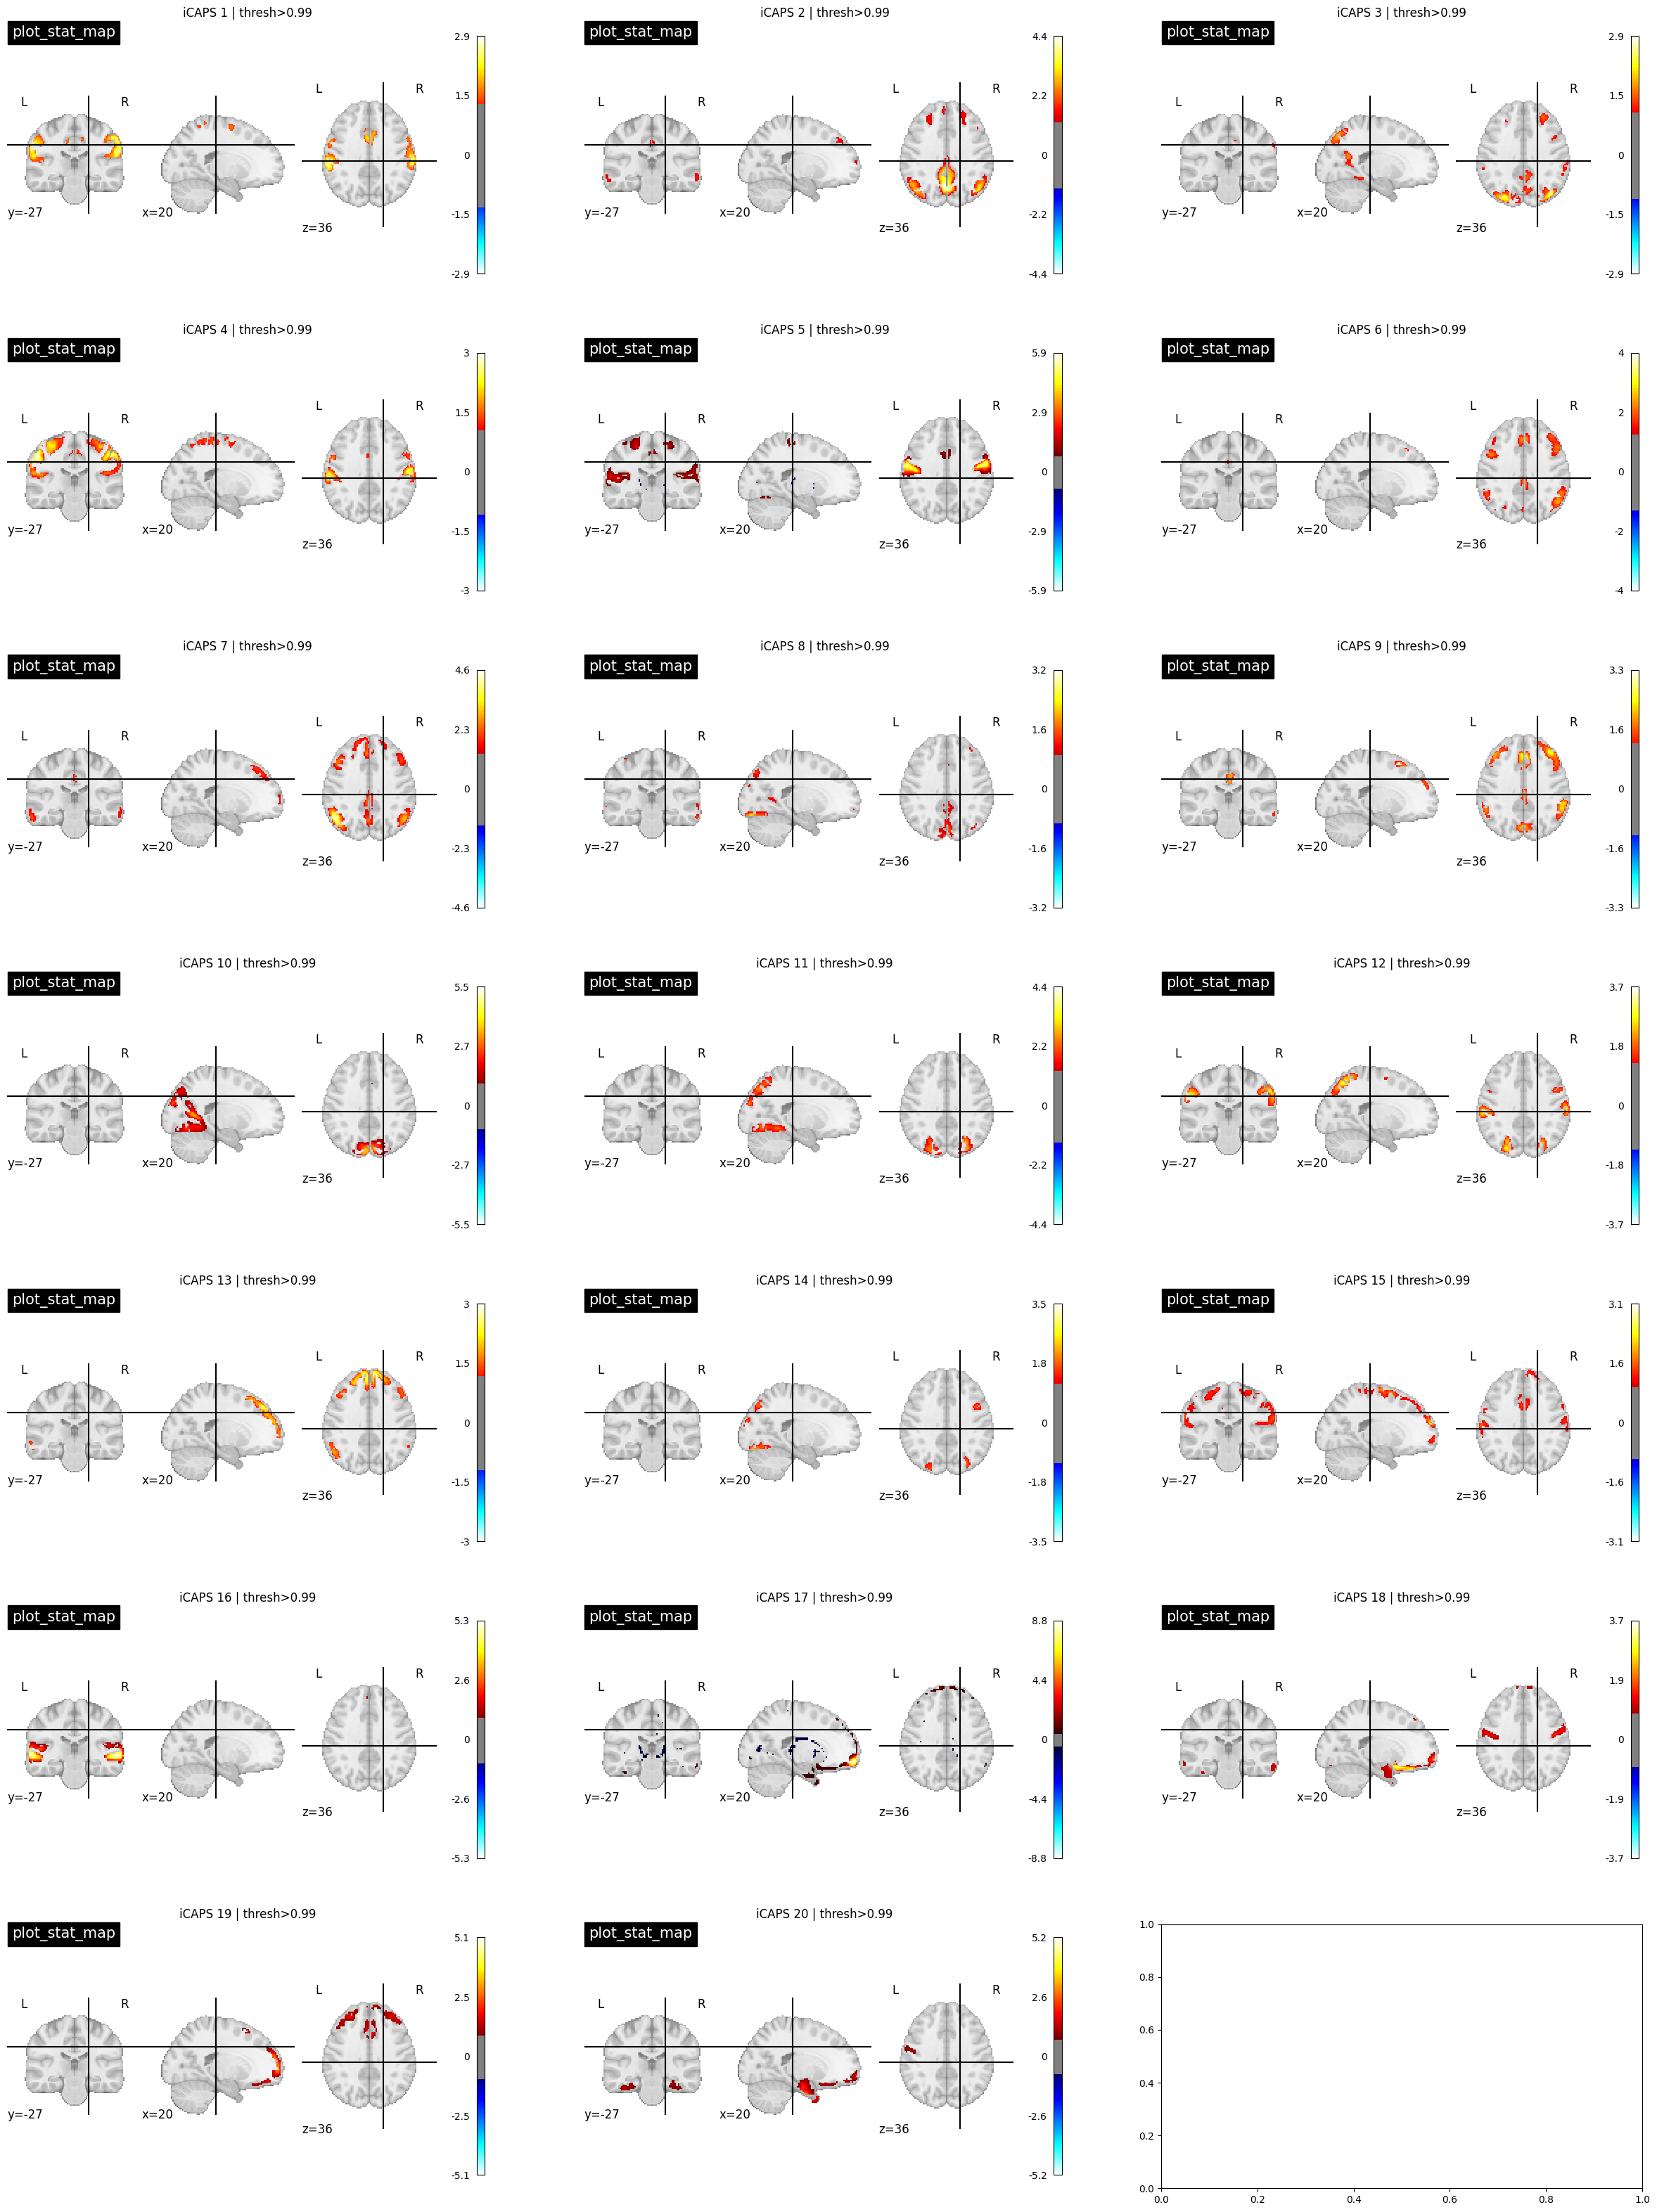

In [68]:
fig, ax = plt.subplots(7,3,figsize=(30,40))
for k in range(20):
    r,c = k//3, k%3
    plotting.plot_stat_map(get_onecaps(group_icaps, tmp.affine, k),
                       threshold=np.percentile(group_icaps[:,:,:,k],perc_thresh),
                       title="plot_stat_map",
                      cut_coords=[20, -27, 36], axes=ax[r,c])
    
    ax[r,c].set_title('iCAPS {} | thresh>0.99'.format(k+1))

In [69]:
tosave = nib.Nifti1Image(group_icaps, tmp.affine)
nib.save(tosave, './resources/groupicaps-1-19.nii.gz')

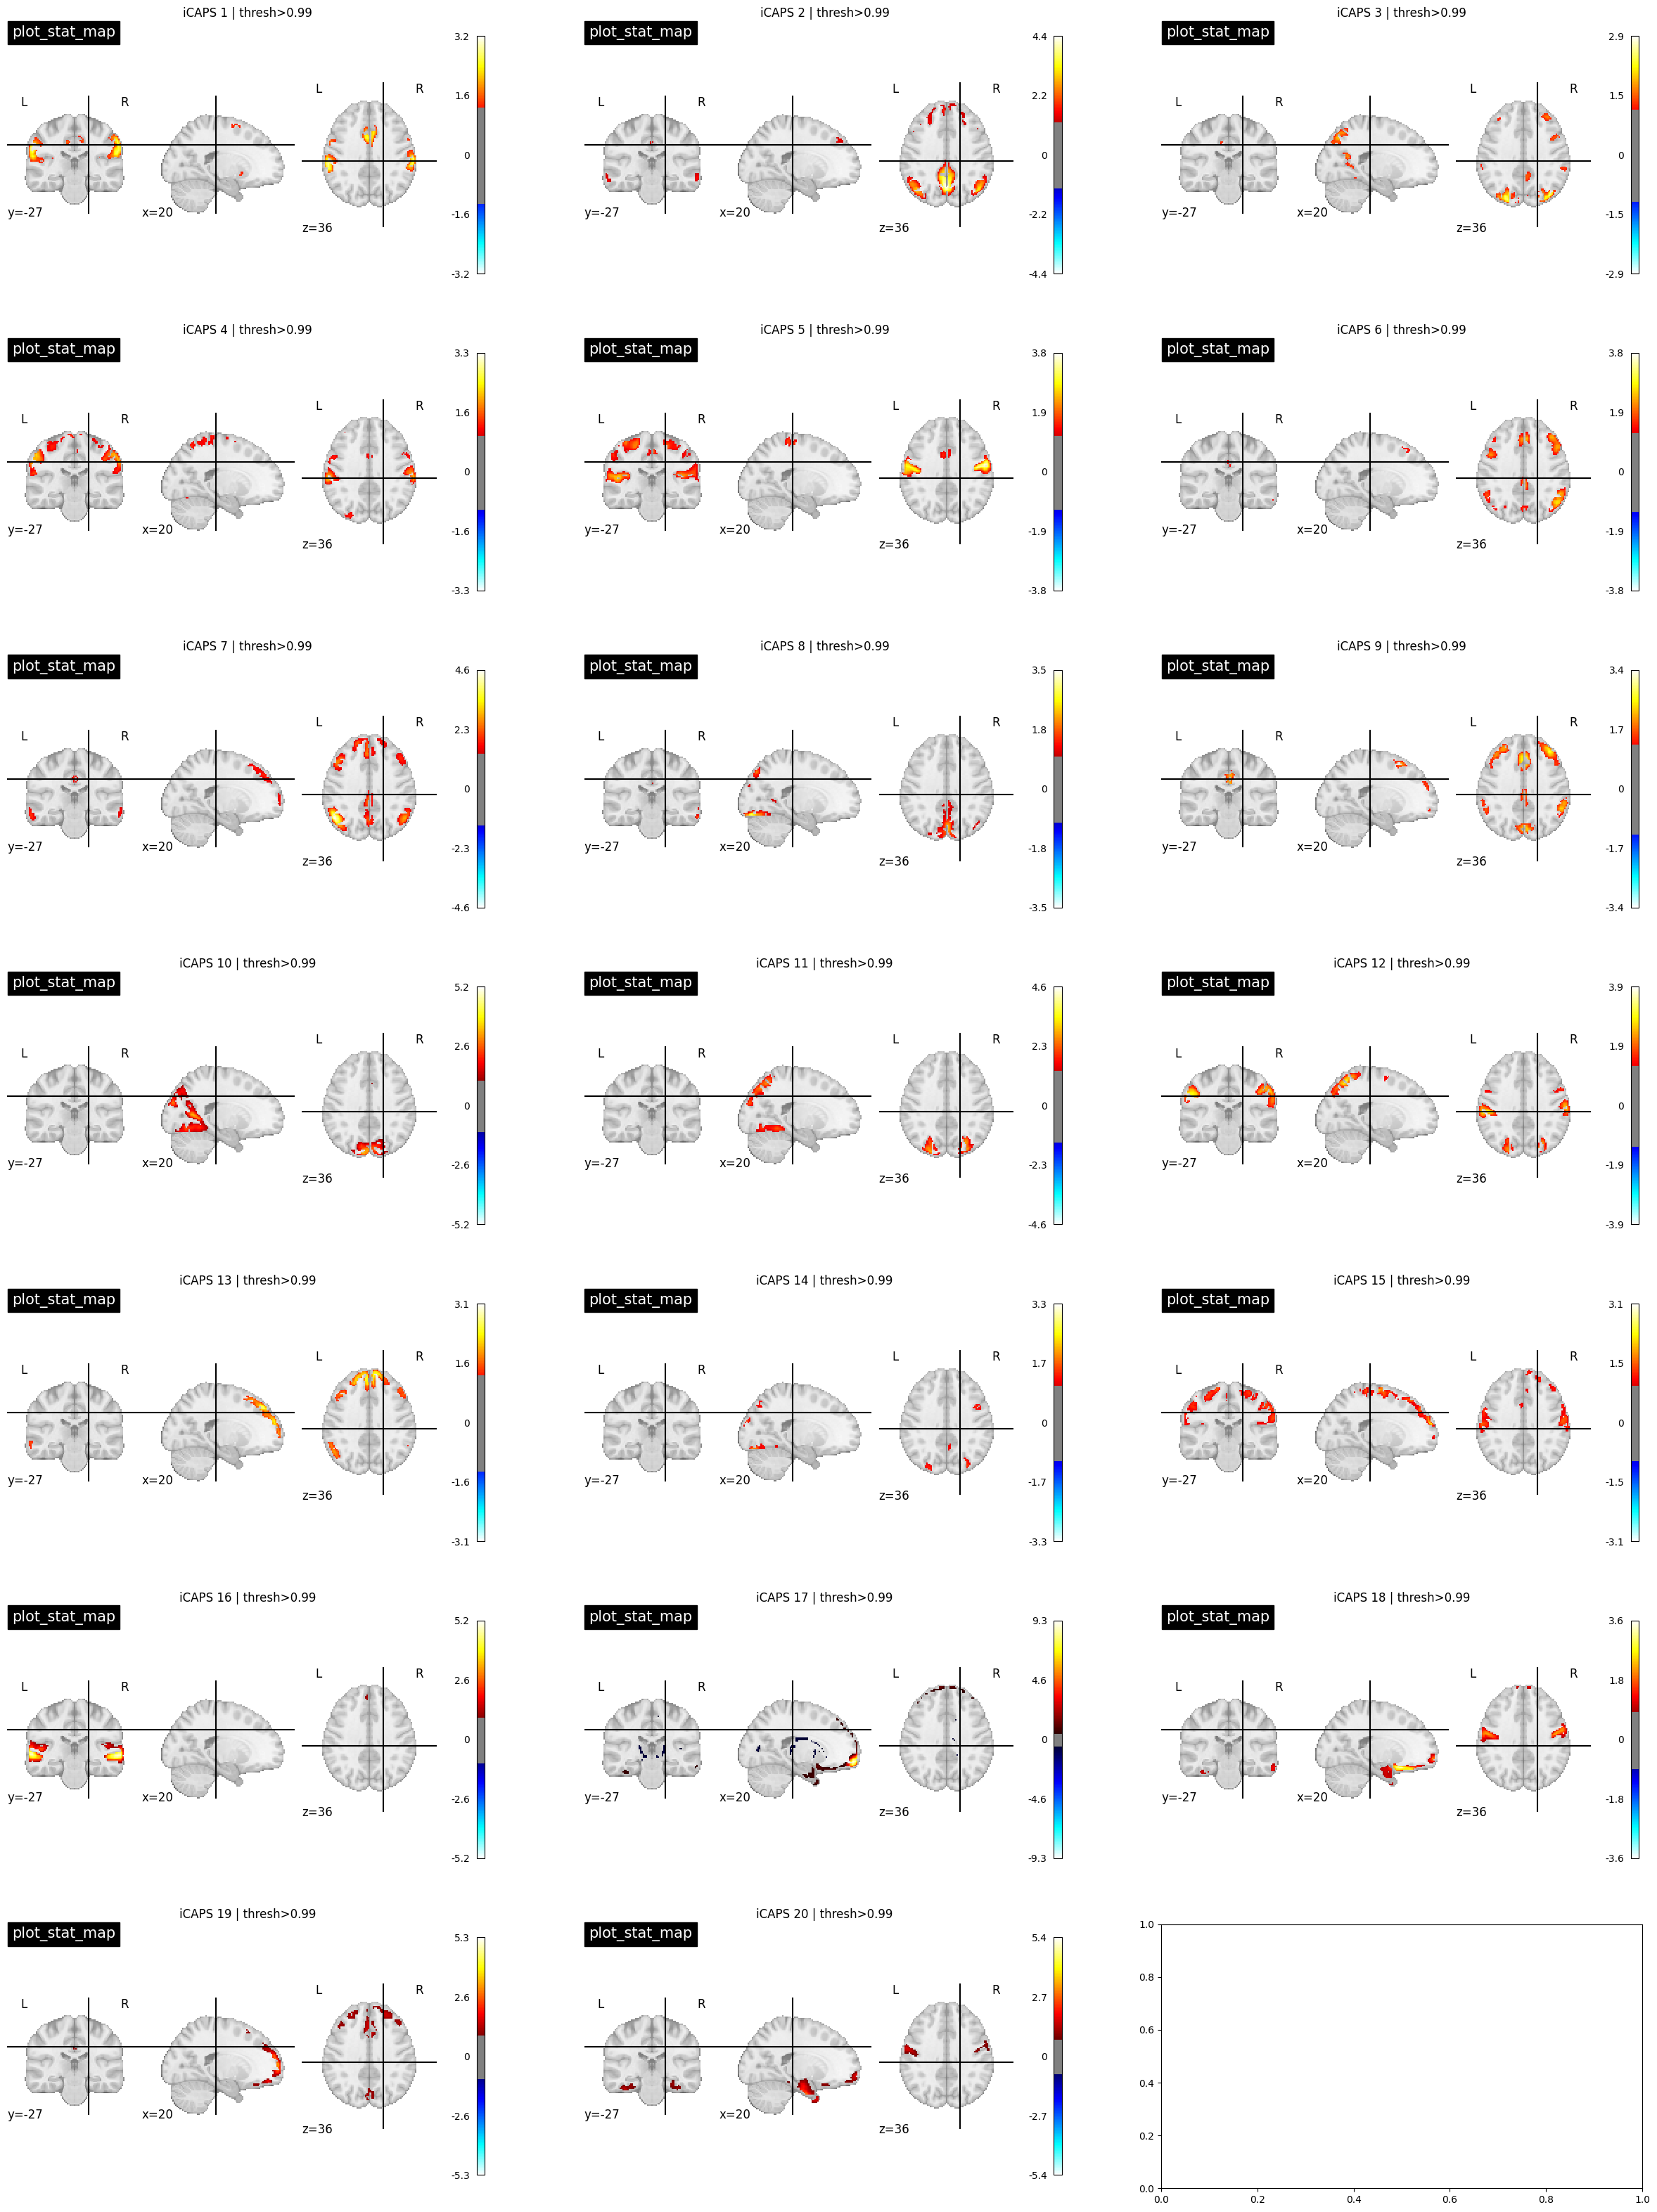

In [69]:
fig, ax = plt.subplots(7,3,figsize=(30,40))
for k in range(20):
    r,c = k//3, k%3
    plotting.plot_stat_map(get_onecaps(group_icaps, tmp.affine, k),
                       threshold=np.percentile(group_icaps[:,:,:,k],perc_thresh),
                       title="plot_stat_map",
                      cut_coords=[20, -27, 36], axes=ax[r,c])
    
    ax[r,c].set_title('iCAPS {} | thresh>0.99'.format(k+1))

In [ ]:
tosave = nib.Nifti1Image(group_icaps, tmp.affine)
nib.save(tosave, './resources/groupicaps-1-15.nii.gz')